# 4.0 Perception-Gap Analysis – LightGBM on Nutri-Score

This notebook performs error and interpretability analysis for the best-performing
LightGBM Nutri-Score model, using the saved predictions and feature importance
from evaluation code.

In [10]:
# 1. Setup & Data Loading

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score,
    f1_score,
)

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

RESULTS_DIR = "../results"
INTERP_DIR = os.path.join(RESULTS_DIR, "interpretability-nutri")
os.makedirs(INTERP_DIR, exist_ok=True)

# Load test set with predictions from modeling pipeline
test = pd.read_csv(
    os.path.join(RESULTS_DIR, "../results/data_def_test_with_lgb_nutri_preds.csv"),
    sep=";",
)
print("Test shape:", test.shape)

# Core slice (robust parsing of core_slice column)
core_norm = (
    test["core_slice"]
    .astype(str)
    .str.strip()
    .str.lower()
)

core_mask = core_norm == "true"
test_core = test[core_mask].copy()

print(f"Core subset size: {len(test_core)} / {len(test)} ({len(test_core)/len(test):.1%})")

# Phase setup
phases = [
    ("phase1_intrinsic",  "Intrinsic"),
    ("phase2_intr+extr",  "Intrinsic + Extrinsic"),
    ("phase3_all_labels", "All Labels"),
]

nutri_classes = sorted(test_core["nutriscore"].unique())
print("Nutri-Score classes:", nutri_classes)

BEST_PHASE_NAME  = "phase3_all_labels" 
BEST_PHASE_LABEL = "All Labels"
BEST_PRED_COL    = f"{BEST_PHASE_NAME}_lgb_pred"

Test shape: (88315, 30)
Core subset size: 4876 / 88315 (5.5%)
Nutri-Score classes: ['a', 'b', 'c', 'd', 'e']


C:\Users\Voorro\AppData\Local\Temp\ipykernel_17112\2616908771.py:24: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(


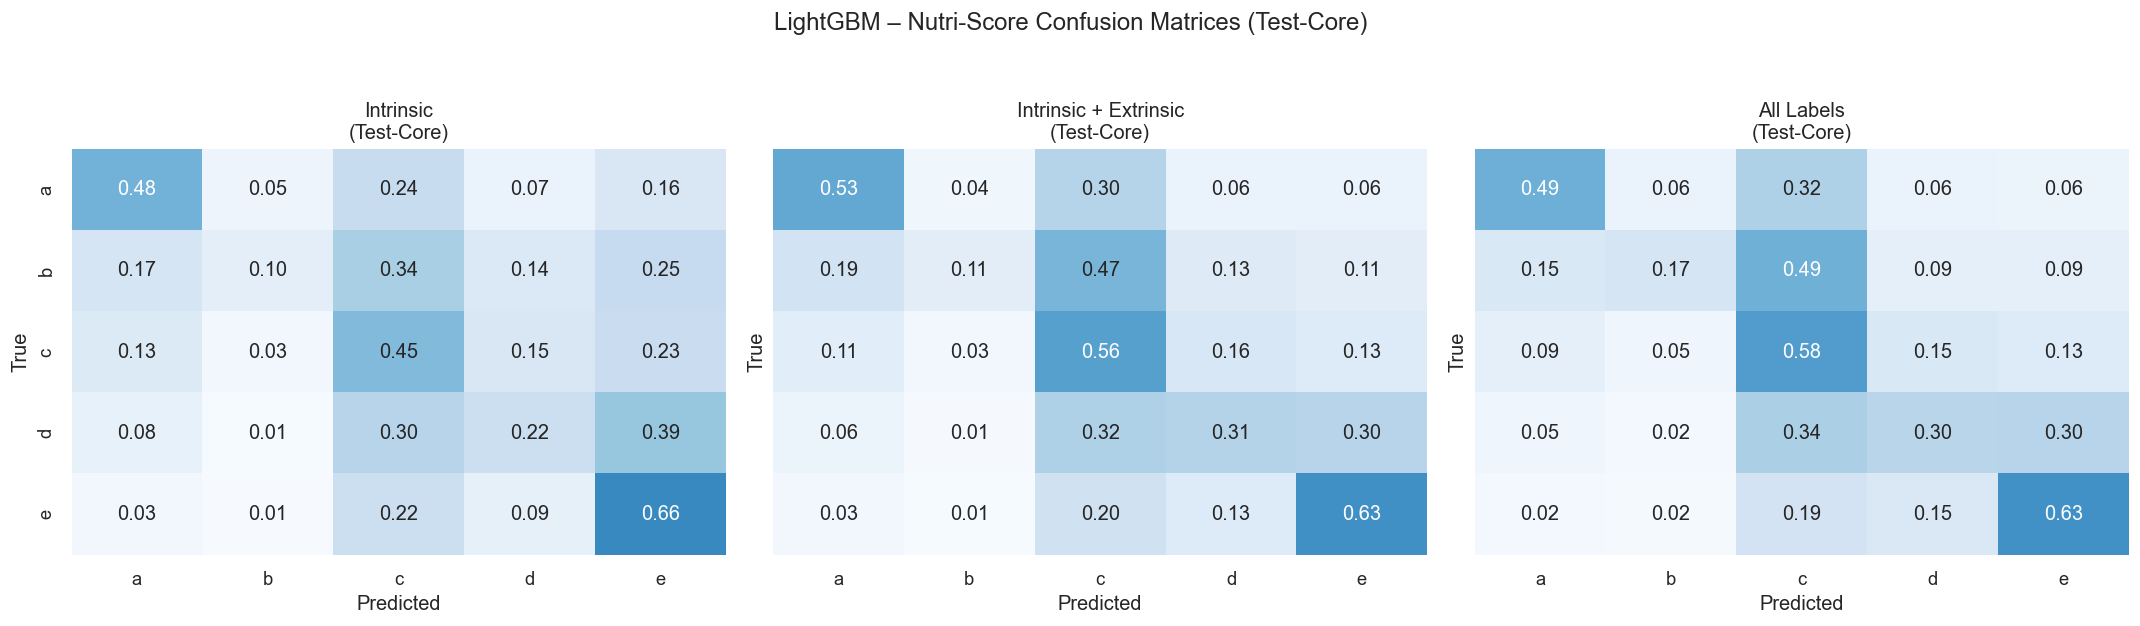

Saved: ../results\interpretability-nutri\confusion_matrices\cm_allphases_testcore.png


In [12]:
# 2. Confusion Matrices (Test-Core)
from sklearn.metrics import confusion_matrix

cm_dir = os.path.join(INTERP_DIR, "confusion_matrices")
os.makedirs(cm_dir, exist_ok=True)

cms = []
for phase_name, phase_label in phases:
    col_pred = f"{phase_name}_lgb_pred"
    y_true = test_core["nutriscore"]
    y_pred = test_core[col_pred]

    cm = confusion_matrix(y_true, y_pred, labels=nutri_classes, normalize="true")
    cms.append(cm)

# Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (phase_name, phase_label), cm in zip(axes, phases, cms):
    sns.heatmap(
        cm,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=nutri_classes,
        yticklabels=nutri_classes,
        cbar=False,
        vmin=0,
        vmax=1,
    )
    ax.set_title(f"{phase_label}\n(Test-Core)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.suptitle("LightGBM – Nutri-Score Confusion Matrices (Test-Core)", y=1.04)
plt.tight_layout()

cm_all_path = os.path.join(cm_dir, "cm_allphases_testcore.png")
plt.savefig(cm_all_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", cm_all_path)

Saved per-class metrics: ../results\interpretability-nutri\per_class_metrics\lgb_nutri_per_class_metrics_testcore.csv


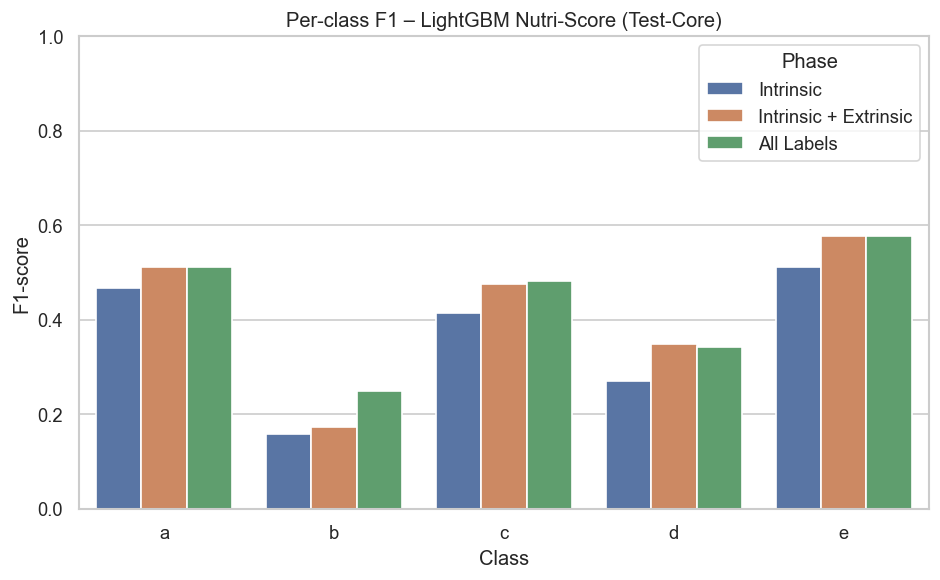

Saved: ../results\interpretability-nutri\per_class_metrics\lgb_nutri_f1_per_class_testcore_allphases.png


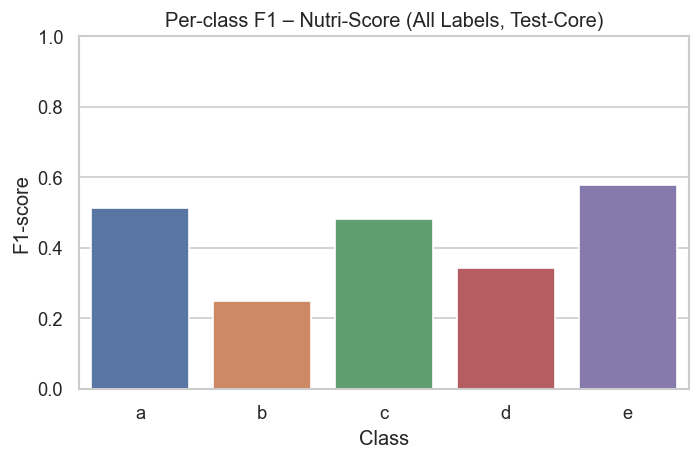

Saved: ../results\interpretability-nutri\per_class_metrics\lgb_nutri_f1_per_class_testcore_bestphase.png


In [14]:
# 3. Per-Class Metrics & F1 Bars (Test-Core)

perclass_dir = os.path.join(INTERP_DIR, "per_class_metrics")
os.makedirs(perclass_dir, exist_ok=True)

perclass_list = []

for phase_name, phase_label in phases:
    col_pred = f"{phase_name}_lgb_pred"
    y_true = test_core["nutriscore"]
    y_pred = test_core[col_pred]

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=nutri_classes,
        zero_division=0,
    )

    df_phase = pd.DataFrame({
        "Class": nutri_classes,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Support": support,
        "Phase": phase_label,
    })
    perclass_list.append(df_phase)

perclass_df = pd.concat(perclass_list, ignore_index=True)

perclass_csv = os.path.join(perclass_dir, "lgb_nutri_per_class_metrics_testcore.csv")
perclass_df.to_csv(perclass_csv, sep=";", index=False)
print("Saved per-class metrics:", perclass_csv)

# F1 bars across phases
plt.figure(figsize=(8, 5))
sns.barplot(
    data=perclass_df,
    x="Class",
    y="F1",
    hue="Phase",
)
plt.ylim(0, 1)
plt.title("Per-class F1 – LightGBM Nutri-Score (Test-Core)")
plt.ylabel("F1-score")
plt.tight_layout()

f1_all_path = os.path.join(perclass_dir, "lgb_nutri_f1_per_class_testcore_allphases.png")
plt.savefig(f1_all_path, dpi=300)
plt.show()
print("Saved:", f1_all_path)

# Best phase only
df_best = perclass_df[perclass_df["Phase"] == BEST_PHASE_LABEL]

plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_best,
    x="Class",
    y="F1",
)
plt.ylim(0, 1)
plt.title(f"Per-class F1 – Nutri-Score ({BEST_PHASE_LABEL}, Test-Core)")
plt.ylabel("F1-score")
plt.tight_layout()

f1_best_path = os.path.join(perclass_dir, "lgb_nutri_f1_per_class_testcore_bestphase.png")
plt.savefig(f1_best_path, dpi=300)
plt.show()
print("Saved:", f1_best_path)

In [5]:
# 4. Error Distribution for Best Phase
y_true_best = test_core["nutriscore"]
y_pred_best = test_core[BEST_PRED_COL]

true_counts = y_true_best.value_counts().sort_index()
pred_counts = y_pred_best.value_counts().sort_index()

dist_df = pd.DataFrame({
    "True_count": true_counts,
    "Pred_count": pred_counts,
})
dist_df["Diff_pred_minus_true"] = dist_df["Pred_count"] - dist_df["True_count"]
dist_df["Rel_diff_%"] = 100 * dist_df["Diff_pred_minus_true"] / dist_df["True_count"]

print("True vs predicted distribution (Test-Core, best phase):")
display(dist_df.round(2))

# Quick misclassification summary per class
from sklearn.metrics import confusion_matrix

cm_counts = confusion_matrix(y_true_best, y_pred_best, labels=nutri_classes)
print("\nTop misclassification per true class:")

for i, cls in enumerate(nutri_classes):
    row = cm_counts[i]
    total = row.sum()
    correct = row[i]
    if total == 0:
        continue

    mis = total - correct
    if mis == 0:
        print(f"  Class {cls}: perfectly classified ({total} samples)")
        continue

    wrong_indices = [j for j in range(len(nutri_classes)) if j != i]
    top_wrong_idx = max(wrong_indices, key=lambda j: row[j])
    top_wrong_cls = nutri_classes[top_wrong_idx]
    mis_rate = mis / total

    print(
        f"  True {cls}: {correct}/{total} correct, "
        f"{mis} misclassified ({mis_rate:.1%}), "
        f"most often predicted as {top_wrong_cls}"
    )

True vs predicted distribution (Test-Core, best phase):


,True_count,Pred_count,Diff_pred_minus_true,Rel_diff_%
a,696,646,-50,-7.18
b,664,266,-398,-59.94
c,1344,1893,549,40.85
d,1074,785,-289,-26.91
e,1098,1286,188,17.12



Top misclassification per true class:
  True a: 343/696 correct, 353 misclassified (50.7%), most often predicted as c
  True b: 116/664 correct, 548 misclassified (82.5%), most often predicted as c
  True c: 779/1344 correct, 565 misclassified (42.0%), most often predicted as d
  True d: 318/1074 correct, 756 misclassified (70.4%), most often predicted as c
  True e: 687/1098 correct, 411 misclassified (37.4%), most often predicted as c


Saved category metrics: ../results\interpretability-nutri\category_level\lgb_nutri_testcore_per_category.csv


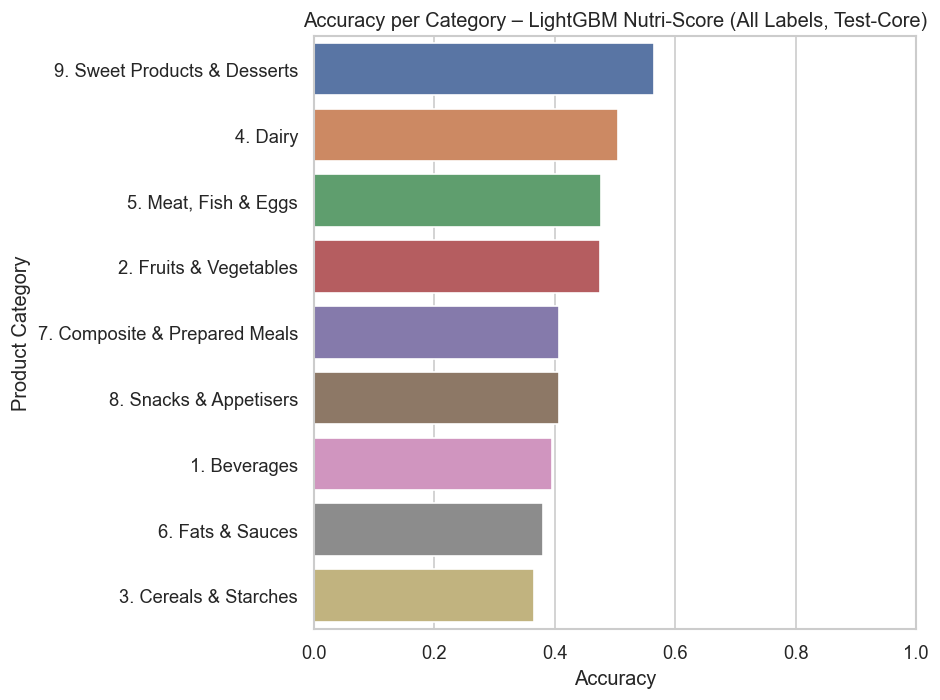

Saved: ../results\interpretability-nutri\category_level\lgb_nutri_testcore_accuracy_per_category.png


In [16]:
# 5. Category-Level Performance (Test-Core)
assert "main_mapped_category" in test_core.columns

cat_dir = os.path.join(INTERP_DIR, "category_level")
os.makedirs(cat_dir, exist_ok=True)

df_cat = test_core.dropna(subset=["main_mapped_category"]).copy()
df_cat["y_true"] = df_cat["nutriscore"]
df_cat["y_pred"] = df_cat[BEST_PRED_COL]

rows = []
for cat, subset in df_cat.groupby("main_mapped_category"):
    if len(subset) < 10:  # skip tiny groups
        continue

    y_true = subset["y_true"]
    y_pred = subset["y_pred"]

    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)

    rows.append({
        "main_mapped_category": cat,
        "n_samples": len(subset),
        "Accuracy": acc,
        "F1_macro": f1m,
    })

cat_perf = pd.DataFrame(rows).sort_values("Accuracy", ascending=False)

cat_csv = os.path.join(cat_dir, "lgb_nutri_testcore_per_category.csv")
cat_perf.to_csv(cat_csv, sep=";", index=False)
print("Saved category metrics:", cat_csv)

# Plot accuracy per category
plt.figure(figsize=(8, max(6, 0.3 * len(cat_perf))))
sns.barplot(
    data=cat_perf,
    y="main_mapped_category",
    x="Accuracy",
)
plt.xlim(0, 1)
plt.title(f"Accuracy per Category – LightGBM Nutri-Score ({BEST_PHASE_LABEL}, Test-Core)")
plt.xlabel("Accuracy")
plt.ylabel("Product Category")
plt.tight_layout()

cat_acc_path = os.path.join(cat_dir, "lgb_nutri_testcore_accuracy_per_category.png")
plt.savefig(cat_acc_path, dpi=300)
plt.show()
print("Saved:", cat_acc_path)

In [18]:
print(cat_perf.to_string(index=False))

         main_mapped_category  n_samples  Accuracy  F1_macro
 9. Sweet Products & Desserts        744  0.564516  0.319093
                     4. Dairy        781  0.504481  0.479943
         5. Meat, Fish & Eggs        712  0.477528  0.436383
       2. Fruits & Vegetables        647  0.474498  0.324253
7. Composite & Prepared Meals        314  0.407643  0.281108
       8. Snacks & Appetisers        452  0.407080  0.392674
                 1. Beverages        597  0.395310  0.296489
             6. Fats & Sauces        287  0.379791  0.381699
        3. Cereals & Starches        342  0.365497  0.286221


Saved category×pred distribution: ../results\interpretability-nutri\category_level\lgb_nutri_category_pred_distribution_testcore.csv


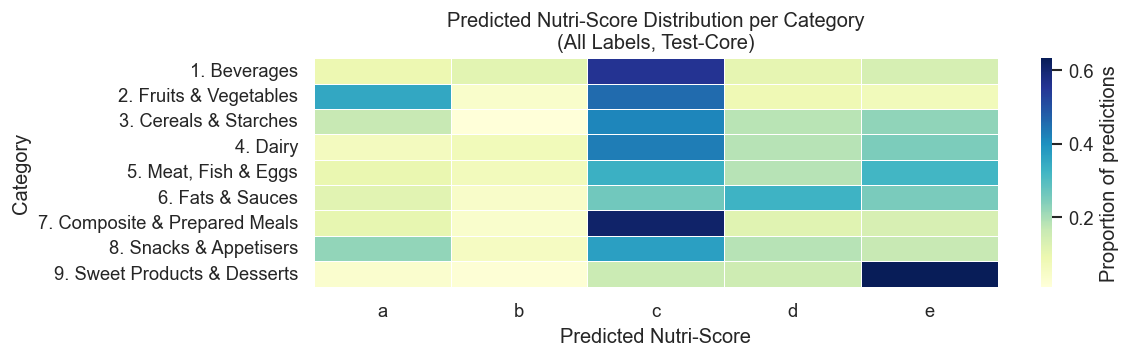

Saved: ../results\interpretability-nutri\category_level\lgb_nutri_testcore_category_pred_heatmap.png


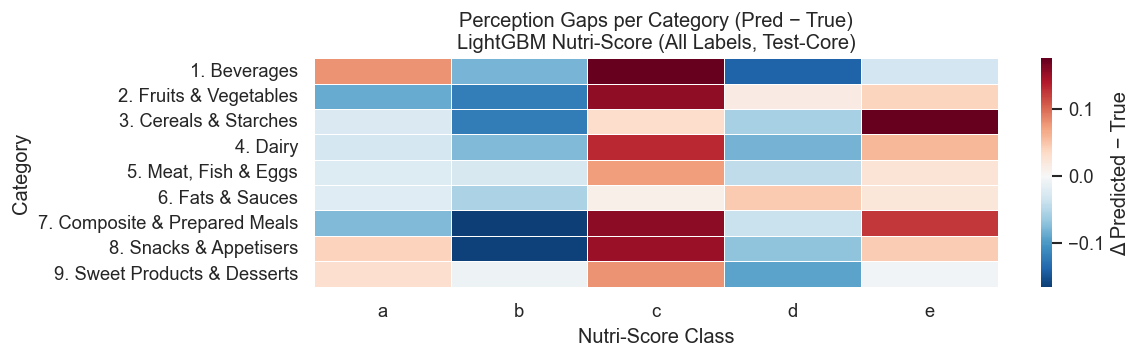

Saved: ../results\interpretability-nutri\category_level\lgb_nutri_testcore_perception_gaps_heatmap.png


In [20]:
# 6. Category × Predicted Distribution & Perception Gaps
# Category × predicted distribution
df_heat = df_cat.copy() 

cat_pred_ct = pd.crosstab(
    index=df_heat["main_mapped_category"],
    columns=df_heat["y_pred"],
    normalize="index",
)

cat_pred_csv = os.path.join(cat_dir, "lgb_nutri_category_pred_distribution_testcore.csv")
cat_pred_ct.to_csv(cat_pred_csv, sep=";")
print("Saved category×pred distribution:", cat_pred_csv)

plt.figure(figsize=(10, 0.35 * len(cat_pred_ct)))
sns.heatmap(
    cat_pred_ct,
    cmap="YlGnBu",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={'label': 'Proportion of predictions'},
)
plt.title(f"Predicted Nutri-Score Distribution per Category\n({BEST_PHASE_LABEL}, Test-Core)")
plt.xlabel("Predicted Nutri-Score")
plt.ylabel("Category")
plt.tight_layout()

cat_pred_png = os.path.join(cat_dir, "lgb_nutri_testcore_category_pred_heatmap.png")
plt.savefig(cat_pred_png, dpi=300)
plt.show()
print("Saved:", cat_pred_png)

# Perception gaps (Pred − True) per category & class
true_ct = pd.crosstab(
    index=df_heat["main_mapped_category"],
    columns=df_heat["y_true"],
    normalize="index",
)

# Align columns
all_classes = sorted(set(true_ct.columns) | set(cat_pred_ct.columns))
true_ct = true_ct.reindex(columns=all_classes, fill_value=0)
pred_ct = cat_pred_ct.reindex(columns=all_classes, fill_value=0)

diff_ct = pred_ct - true_ct

true_ct.to_csv(os.path.join(cat_dir, "lgb_nutri_true_distribution_testcore.csv"), sep=";")
pred_ct.to_csv(os.path.join(cat_dir, "lgb_nutri_pred_distribution_testcore.csv"), sep=";")
diff_ct.to_csv(os.path.join(cat_dir, "lgb_nutri_perception_gap_testcore.csv"), sep=";")

plt.figure(figsize=(10, 0.35 * len(diff_ct)))
sns.heatmap(
    diff_ct,
    cmap="RdBu_r",
    center=0,
    linewidths=0.3,
    linecolor="white",
    cbar_kws={'label': 'Δ Predicted − True'},
)
plt.title(f"Perception Gaps per Category (Pred − True)\nLightGBM Nutri-Score ({BEST_PHASE_LABEL}, Test-Core)")
plt.xlabel("Nutri-Score Class")
plt.ylabel("Category")
plt.tight_layout()

gap_png = os.path.join(cat_dir, "lgb_nutri_testcore_perception_gaps_heatmap.png")
plt.savefig(gap_png, dpi=300)
plt.show()
print("Saved:", gap_png)

Saved gap summary: ../results\interpretability-nutri\category_level\lgb_nutri_perception_gap_summary_testcore.csv


D:\ProgramFilesFolder\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
D:\ProgramFilesFolder\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


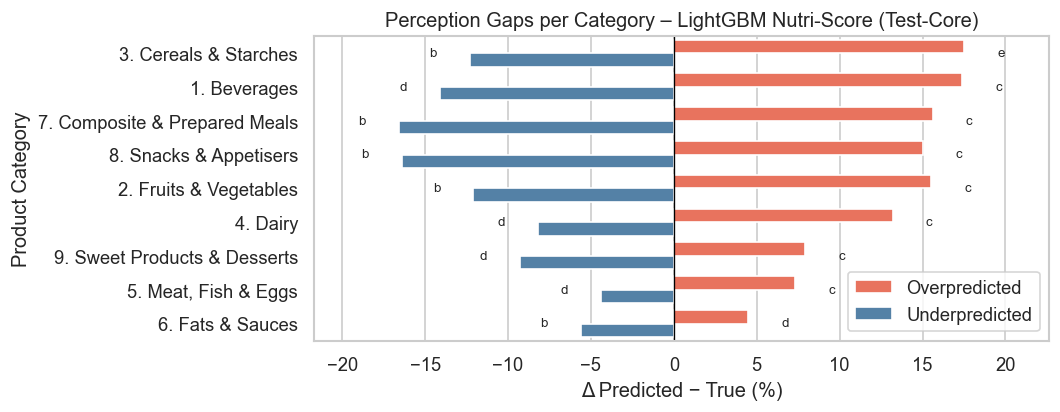

Saved: ../results\interpretability-nutri\category_level\lgb_nutri_testcore_perception_gaps_barchart.png


In [27]:
# 7. Category-Level Gap Summary + Bar Chart
# Build summary of top over/under-predicted classes per category
diff_ct = diff_ct 

rows_summary = []
for cat, row in diff_ct.iterrows():
    sorted_over = row.sort_values(ascending=False)
    sorted_under = row.sort_values(ascending=True)

    top_over_class = sorted_over.index[0]
    top_over_val = sorted_over.iloc[0] * 100
    top_under_class = sorted_under.index[0]
    top_under_val = sorted_under.iloc[0] * 100

    rows_summary.append({
        "main_mapped_category": cat,
        "Top_OverPredicted_Class": top_over_class,
        "OverPredicted_Delta_%": round(top_over_val, 1),
        "Top_UnderPredicted_Class": top_under_class,
        "UnderPredicted_Delta_%": round(top_under_val, 1),
    })

gap_summary_df = pd.DataFrame(rows_summary)

gap_summary_csv = os.path.join(cat_dir, "lgb_nutri_perception_gap_summary_testcore.csv")
gap_summary_df.to_csv(gap_summary_csv, sep=";", index=False)
print("Saved gap summary:", gap_summary_csv)

# Long format for bar chart
plot_df = pd.concat([
    pd.DataFrame({
        "Category": gap_summary_df["main_mapped_category"],
        "Delta_%": gap_summary_df["OverPredicted_Delta_%"],
        "Class": gap_summary_df["Top_OverPredicted_Class"],
        "Type": "Overpredicted",
    }),
    pd.DataFrame({
        "Category": gap_summary_df["main_mapped_category"],
        "Delta_%": gap_summary_df["UnderPredicted_Delta_%"],
        "Class": gap_summary_df["Top_UnderPredicted_Class"],
        "Type": "Underpredicted",
    }),
])

plot_df["abs_delta"] = plot_df["Delta_%"].abs()
ordered_cats = plot_df.groupby("Category")["abs_delta"].max().sort_values(ascending=False).index
plot_df["Category"] = pd.Categorical(plot_df["Category"], categories=ordered_cats, ordered=True)
cat_to_y = {cat: i for i, cat in enumerate(ordered_cats)}

plt.figure(figsize=(9, 0.4 * len(ordered_cats)))
sns.barplot(
    data=plot_df,
    y="Category",
    x="Delta_%",
    hue="Type",
    palette={"Overpredicted": "tomato", "Underpredicted": "steelblue"},
)

# Expand x-limits so class letters stay inside
x_min = plot_df["Delta_%"].min()
x_max = plot_df["Delta_%"].max()
padding = (x_max - x_min) * 0.15
plt.xlim(x_min - padding, x_max + padding)

plt.axvline(0, color="black", linewidth=0.8)
plt.title("Perception Gaps per Category – LightGBM Nutri-Score (Test-Core)")
plt.xlabel("Δ Predicted − True (%)")
plt.ylabel("Product Category")

for _, row in plot_df.iterrows():
    y = cat_to_y[row["Category"]]
    plt.text(
        row["Delta_%"] + (2 if row["Delta_%"] > 0 else -2),
        y,
        row["Class"],
        va="center",
        ha="left" if row["Delta_%"] > 0 else "right",
        fontsize=8,
    )

plt.legend(title="", loc="lower right")
plt.tight_layout()

gap_bar_png = os.path.join(cat_dir, "lgb_nutri_testcore_perception_gaps_barchart.png")
plt.savefig(gap_bar_png, dpi=300)
plt.show()
print("Saved:", gap_bar_png)

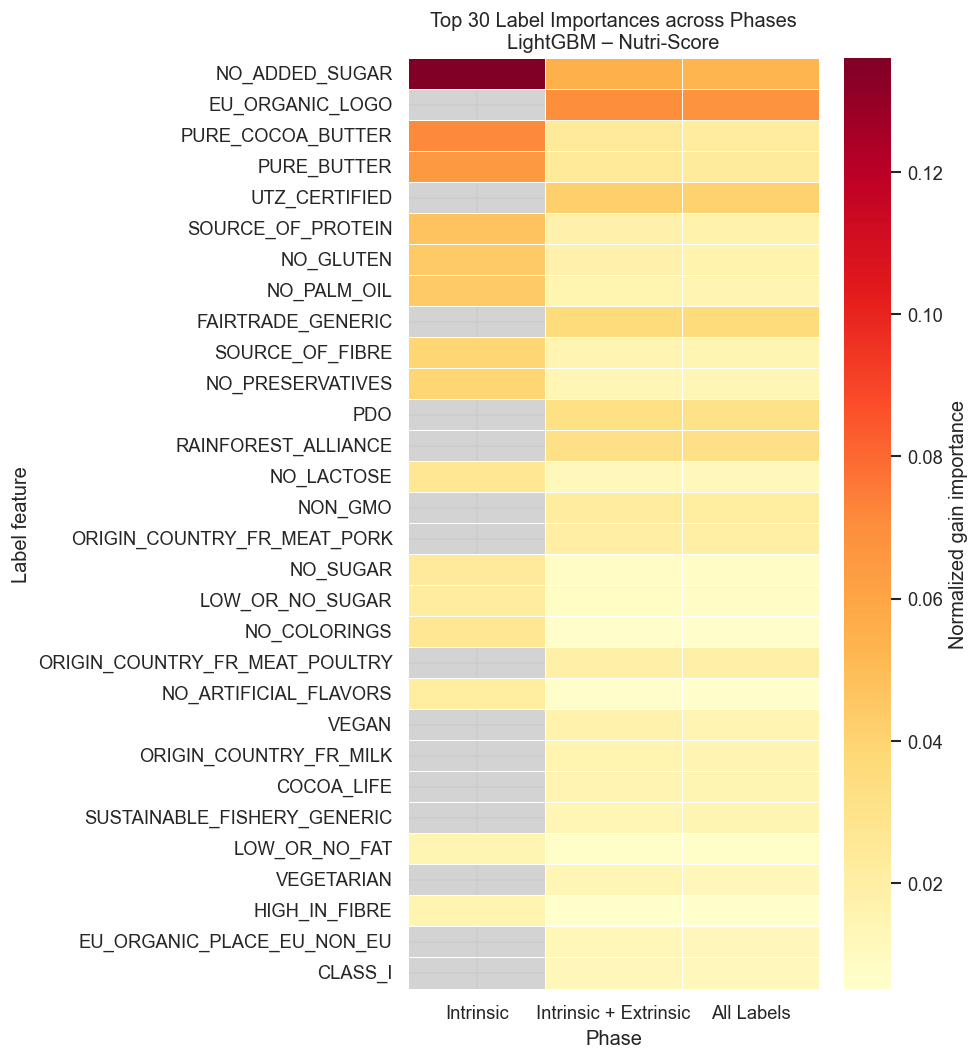

Saved: ../results\interpretability-nutri\feature_importance\lgb_nutri_feature_importance_heatmap_crossphase_top30.png


In [31]:
# 8. Feature Importance – Cross-Phase & New Labels
fi_dir = os.path.join(INTERP_DIR, "feature_importance")
os.makedirs(fi_dir, exist_ok=True)

fi_all = pd.read_csv(
    os.path.join("../results", "feature_importance", "lgb_nutri_feature_importance_all_phases.csv"),
    sep=";",
)

fi_pivot = fi_all.pivot_table(
    index="feature",
    columns="Phase",
    values="importance_gain_norm",
    aggfunc="sum",
)

p1 = "phase1_intrinsic"
p2 = "phase2_intr+extr"
p3 = "phase3_all_labels"

# For ranking, treat NaNs as 0
fi_rank = fi_pivot.fillna(0)
fi_rank["overall_mean"] = fi_rank.mean(axis=1)

top_features = fi_rank.sort_values("overall_mean", ascending=False).head(30).index
fi_top = fi_pivot.loc[top_features]

# Rename phases
col_renames = {
    p1: "Intrinsic",
    p2: "Intrinsic + Extrinsic",
    p3: "All Labels",
}
fi_top = fi_top.rename(columns=col_renames)
fi_top = fi_top[["Intrinsic", "Intrinsic + Extrinsic", "All Labels"]]

# Mask NaNs (=feature not present in that phase)
mask = fi_top.isna()
fi_plot = fi_top.fillna(0)

plt.figure(figsize=(8, 9))
ax = sns.heatmap(
    fi_plot,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Normalized gain importance"},
    mask=mask,
)
ax.set_facecolor("lightgrey")  # grey = not present

plt.title("Top 30 Label Importances across Phases\nLightGBM – Nutri-Score")
plt.xlabel("Phase")
plt.ylabel("Label feature")
plt.tight_layout()

fi_cross_png = os.path.join(fi_dir, "lgb_nutri_feature_importance_heatmap_crossphase_top30.png")
plt.savefig(fi_cross_png, dpi=300)
plt.show()
print("Saved:", fi_cross_png)

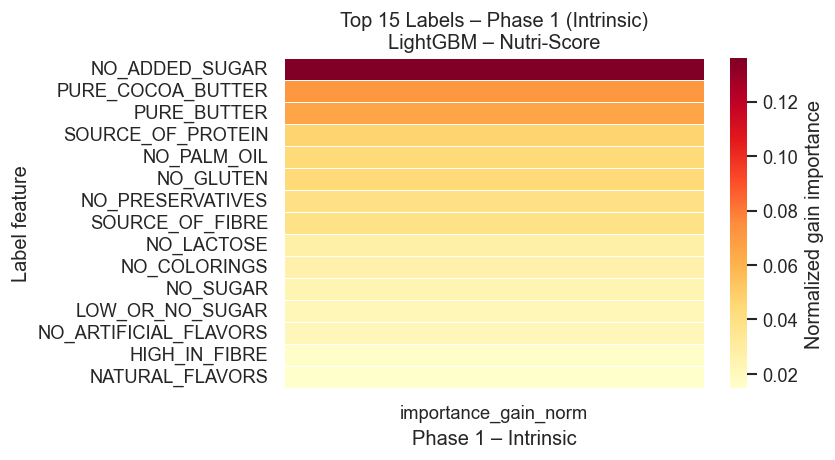

Saved: ../results\interpretability-nutri\feature_importance\lgb_nutri_phase1_top15_heatmap.png


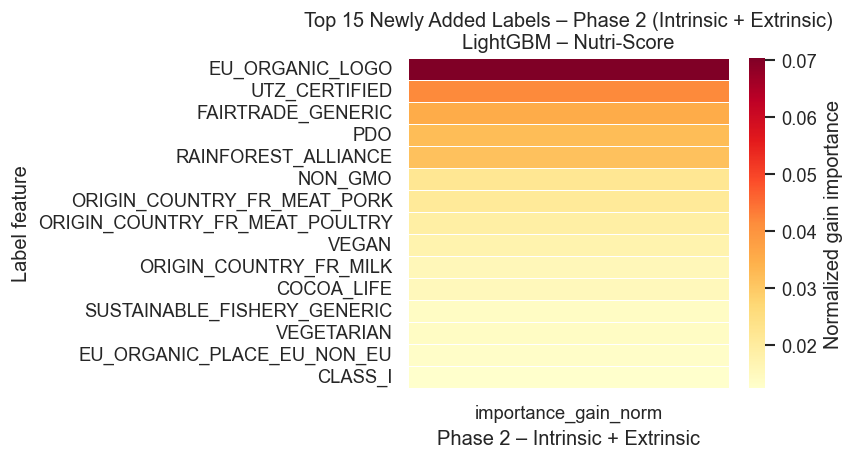

Saved: ../results\interpretability-nutri\feature_importance\lgb_nutri_phase2_newlabels_top15_heatmap.png


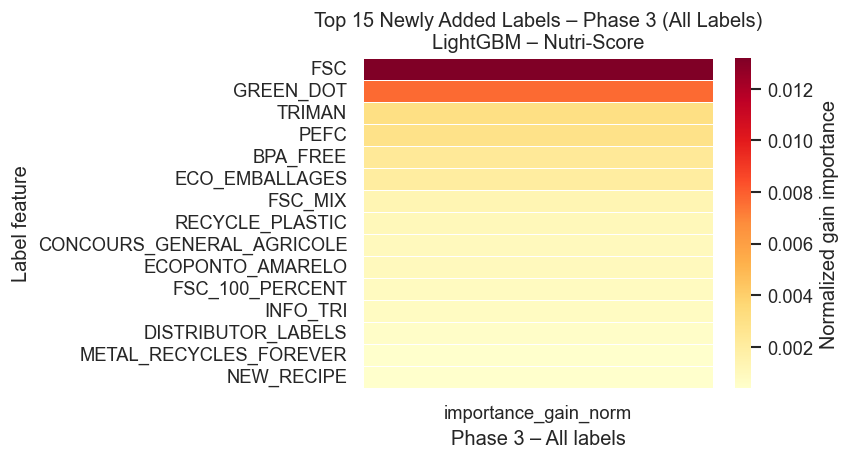

Saved: ../results\interpretability-nutri\feature_importance\lgb_nutri_phase3_newlabels_top15_heatmap.png


In [33]:
# 9. Phase-specific “new label” plots
# Phase 1: baseline intrinsic labels (top 15) 
fi_phase1 = fi_all[fi_all["Phase"] == p1].copy()
fi_phase1 = fi_phase1.sort_values("importance_gain_norm", ascending=False).head(15)

hm_p1 = fi_phase1.set_index("feature")[["importance_gain_norm"]]

plt.figure(figsize=(7, max(4, 0.25 * len(hm_p1))))
sns.heatmap(
    hm_p1,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Normalized gain importance"},
)
plt.title("Top 15 Labels – Phase 1 (Intrinsic)\nLightGBM – Nutri-Score")
plt.xlabel("Phase 1 – Intrinsic")
plt.ylabel("Label feature")
plt.tight_layout()

p1_png = os.path.join(fi_dir, "lgb_nutri_phase1_top15_heatmap.png")
plt.savefig(p1_png, dpi=300)
plt.show()
print("Saved:", p1_png)


# Phase 2: labels newly introduced in Phase 2 
new_p2_mask = (~fi_pivot[p2].isna()) & fi_pivot[p1].isna()
new_p2_features = fi_pivot.index[new_p2_mask]

fi_phase2_new = fi_all[
    (fi_all["Phase"] == p2) & (fi_all["feature"].isin(new_p2_features))
].copy()
fi_phase2_new = fi_phase2_new.sort_values("importance_gain_norm", ascending=False).head(15)

hm_p2 = fi_phase2_new.set_index("feature")[["importance_gain_norm"]]

plt.figure(figsize=(7, max(4, 0.25 * len(hm_p2))))
sns.heatmap(
    hm_p2,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Normalized gain importance"},
)
plt.title("Top 15 Newly Added Labels – Phase 2 (Intrinsic + Extrinsic)\nLightGBM – Nutri-Score")
plt.xlabel("Phase 2 – Intrinsic + Extrinsic")
plt.ylabel("Label feature")
plt.tight_layout()

p2_new_png = os.path.join(fi_dir, "lgb_nutri_phase2_newlabels_top15_heatmap.png")
plt.savefig(p2_new_png, dpi=300)
plt.show()
print("Saved:", p2_new_png)


# Phase 3: labels newly introduced in Phase 3
new_p3_mask = (~fi_pivot[p3].isna()) & fi_pivot[p1].isna() & fi_pivot[p2].isna()
new_p3_features = fi_pivot.index[new_p3_mask]

fi_phase3_new = fi_all[
    (fi_all["Phase"] == p3) & (fi_all["feature"].isin(new_p3_features))
].copy()
fi_phase3_new = fi_phase3_new.sort_values("importance_gain_norm", ascending=False).head(15)

hm_p3 = fi_phase3_new.set_index("feature")[["importance_gain_norm"]]

plt.figure(figsize=(7, max(4, 0.25 * len(hm_p3))))
sns.heatmap(
    hm_p3,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor="white",
    cbar_kws={"label": "Normalized gain importance"},
)
plt.title("Top 15 Newly Added Labels – Phase 3 (All Labels)\nLightGBM – Nutri-Score")
plt.xlabel("Phase 3 – All labels")
plt.ylabel("Label feature")
plt.tight_layout()

p3_new_png = os.path.join(fi_dir, "lgb_nutri_phase3_newlabels_top15_heatmap.png")
plt.savefig(p3_new_png, dpi=300)
plt.show()
print("Saved:", p3_new_png)